<a href="https://colab.research.google.com/github/pravin-raut/MachineLearning/blob/Master/dissertation/Oil_Forecast_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing the required libraries*

In [4]:
!pip install pmdarima
!pip install quandl
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.0 MB/s eta 0:00:00


# Importing the required packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime,timedelta
import json
import quandl

In [6]:
import urllib.request

file_path = "https://raw.githubusercontent.com/pravin-raut/MachineLearning/Master/dissertation/Config/Config_Git.json"

# Open the file for reading and load the data from it
with urllib.request.urlopen(file_path) as infile:
  data = json.load(infile)
# Set up API key
  api_key=data["nasdaq"]["api_key"]
quandl.ApiConfig.api_key = api_key


# Dates for which data will be extracted

In [7]:
CurrentDate = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')
CurrentDate
FirstDay='2021-01-01'


In [8]:

def getDataFromAPI(API,symbol,start_date,end_date):

  if API=="YFinance":
    # Create a ticker object
    ticker = yf.Ticker(symbol)
    # Download historical data
    data = ticker.history(period="1d", start=start_date, end=end_date)

  if API=="Nasdaq":
    data = quandl.get(symbol,start_date=start_date,end_date=end_date)


  return data

# Get OPEC Oil price data for Nasdaq

In [19]:

OilPriceInUSD=getDataFromAPI("Nasdaq","OPEC/ORB",FirstDay,CurrentDate).reset_index()
OilPriceInUSD['Date'] = pd.to_datetime(OilPriceInUSD['Date']).dt.date
OilPriceInUSD.set_index('Date', inplace=True)
OilPriceInUSD

OilPriceInUSD=OilPriceInUSD.asfreq('b')
OilPriceInUSD['Original_Oil_Price']=OilPriceInUSD.Value.fillna(method='bfill')
df_Oil_InUSD=OilPriceInUSD[['Original_Oil_Price']]
df_Oil_InUSD

,Original_Oil_Price
Date,
2021-01-04,51.35
2021-01-05,50.75
2021-01-06,53.29
2021-01-07,53.84
2021-01-08,54.39
...,...
2023-07-03,76.12
2023-07-04,76.18
2023-07-05,76.60


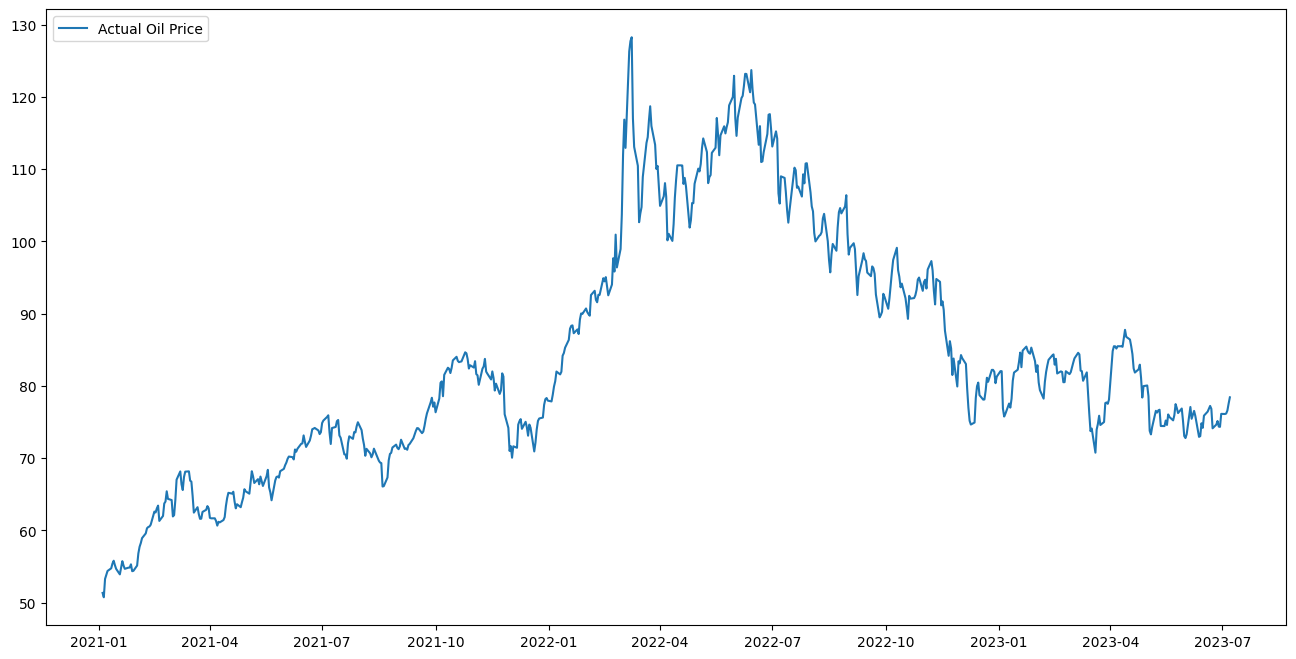

In [10]:
plt.figure(figsize=(16,8))
plt.plot(OilPriceInUSD['Original_Oil_Price'],label="Actual Oil Price")
plt.legend(loc="upper left")

# Finding optimal values of p,d,q for ARIMA

## *   **AR term (p)**
This are lags of dependent variables. e.g. predictors for x(t) is x
(t-1) + x(t-2) + x(t-3).

## *   **Differentiation (d)**
This are number of occasions where we apply differentiation.

## *   **MA term (q)**
This are lags for errors in prediction e.g. predictor for x(t) is e(t-1) + e(t-2) + e(t-3), where e(i) is the difference between the moving average value and the actual value.




In [11]:
from statsmodels.tsa.stattools import adfuller

def perform_adfuller(series):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series)

    # Extract test statistics and p-value
    test_statistic = result[0]
    p_value = result[1]

    # Print the results
    print("Augmented Dickey-Fuller Test:")
    print(f"Test Statistic: {test_statistic}")
    print(f"P-value: {p_value}")

    # Check the p-value against a significance level (e.g., 0.05) to determine stationarity
    if p_value <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")



#Check if data is stationary by doing differnce

In [13]:
perform_adfuller(df_Oil_InUSD['Original_Oil_Price'].diff(1).dropna())

Augmented Dickey-Fuller Test:
Test Statistic: -5.618276794072537
P-value: 1.1608217978097793e-06
The time series is stationary.


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

def plot_acf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_acf(data.dropna(), lags=lags, ax=ax,zero=False)
    plt.title('ACF')
    plt.show()

def plot_pacf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_pacf(data.dropna(), lags=lags, ax=ax,zero=False,alpha=0.05)
    plt.title('PACF')
    plt.show()


# Verifying the lags which can be selected for Training the model
## The lag value where the chart crosses the confidence interval for the first time can be good starting to point to select values of P(ACF) and Q(PACF)

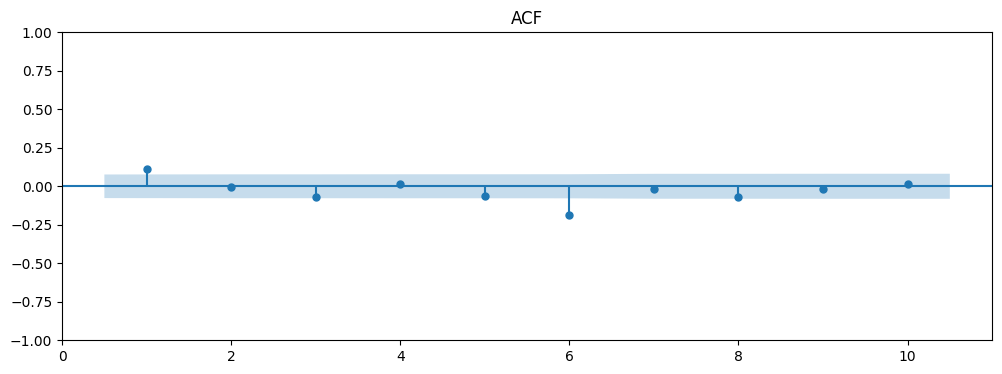

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


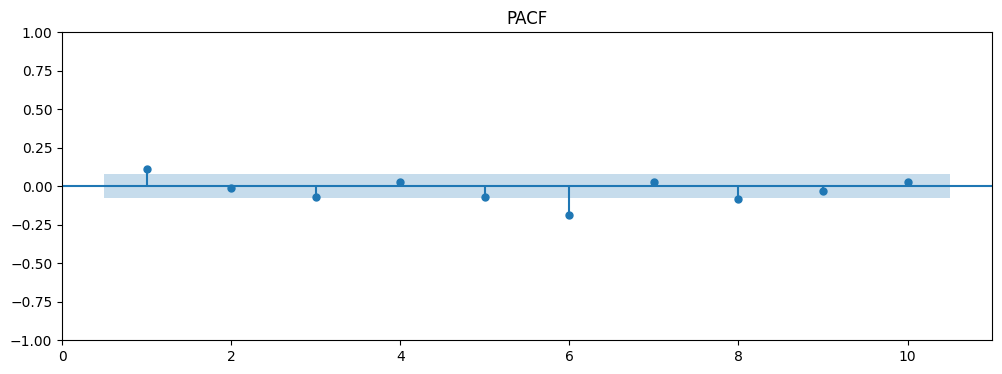

In [15]:
plot_acf_values(df_Oil_InUSD['Original_Oil_Price'].diff(1).dropna(),10)
plot_pacf_values(df_Oil_InUSD['Original_Oil_Price'].diff(1).dropna(),10)

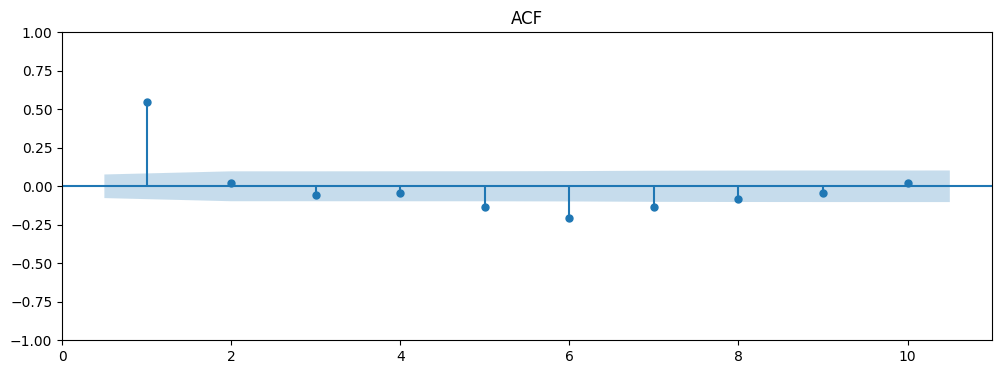

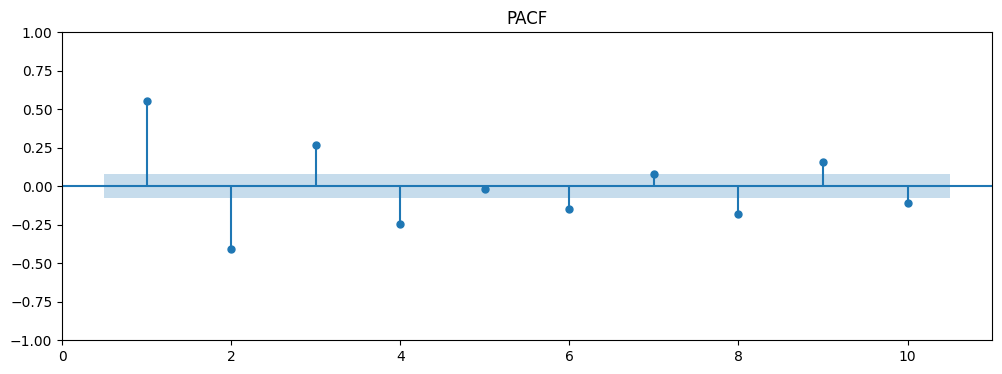

In [16]:
plot_acf_values(df_Oil_InUSD['Original_Oil_Price'].diff(2).dropna(),10)
plot_pacf_values(df_Oil_InUSD['Original_Oil_Price'].diff(2).dropna(),10)

# Defining Training and Testing timeline

In [17]:
# Define the start and end dates for train and test data
train_start_date = pd.to_datetime(FirstDay)
train_end_date = pd.to_datetime('2022-12-31')
test_start_date = pd.to_datetime('2023-01-01')


In [20]:
train_data_oil = df_Oil_InUSD[(df_Oil_InUSD.index >= train_start_date) & (df_Oil_InUSD.index <= train_end_date)]
test_data_oil = df_Oil_InUSD[df_Oil_InUSD.index >= test_start_date]
train_data_oil.head(5)



,Original_Oil_Price
Date,
2021-01-04,51.35
2021-01-05,50.75
2021-01-06,53.29
2021-01-07,53.84
2021-01-08,54.39


In [ ]:
df=train_data_oil

# Auto Arima to find values of p,d,q

In [23]:
from pmdarima import auto_arima
model = auto_arima(train_data_oil['Original_Oil_Price'].dropna(),
                   start_p=1, max_p=5, start_q=1, max_q=5,d=2,
                         seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)
model.summary()


 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2478.947, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2370.790, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2336.761, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2300.605, Time=0.22 sec
 ARI

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  520
Model:               SARIMAX(4, 2, 0)   Log Likelihood               -1138.421
Date:                Mon, 10 Jul 2023   AIC                           2288.842
Time:                        21:30:16   BIC                           2314.342
Sample:                    01-04-2021   HQIC                          2298.833
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0032      0.099     -0.033      0.974      -0.197       0.191
ar.L1         -0.6639      0.030    -22.425      0.000      -0.722      -0.606
ar.L2         -0.4721      0.038    -12.368      0.000      -0.547      -0.397
ar.L3         -0.3668      0.039     -9.395      0.000      -0.443      -0.290
ar.L4         -0.1618      0.032     -4.978      0.000      -0.225      -0.098
sigma2         4.7411      0.186     25.465      0.000       4.376       5.106
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               440.64
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               4.61   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import warnings
warnings.filterwarnings("ignore")


#After verifying manually diffrent values , along with what was observed from plot_acf and plot_pacf decided values of p,d,q

In [33]:
from statsmodels.tsa.arima.model import ARIMA

oil_model=ARIMA(train_data_oil['Original_Oil_Price'],order=(3,2,1))
oil_model_fit=oil_model.fit()
oil_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Original_Oil_Price   No. Observations:                  520
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -1087.877
Date:                Mon, 10 Jul 2023   AIC                           2185.753
Time:                        21:33:13   BIC                           2207.003
Sample:                    01-04-2021   HQIC                          2194.079
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1155      0.034      3.408      0.001       0.049       0.182
ar.L2          0.0009      0.036      0.024      0.980      -0.070       0.072
ar.L3         -0.0726      0.021     -3.500      0.000      -0.113      -0.032
ma.L1         -0.9957      0.008   -123.555      0.000      -1.012      -0.980
sigma2         3.8702      0.124     31.128      0.000       3.627       4.114
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1317.47
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               4.64   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
from statsmodels.tsa.arima.model import ARIMA

oil_model=ARIMA(train_data_oil['Original_Oil_Price'],order=(1,2,3))
oil_model_fit=oil_model.fit()
oil_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Original_Oil_Price   No. Observations:                  520
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1088.267
Date:                Mon, 10 Jul 2023   AIC                           2186.533
Time:                        21:32:59   BIC                           2207.783
Sample:                    01-04-2021   HQIC                          2194.859
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9380      0.063    -14.828      0.000      -1.062      -0.814
ma.L1          0.0563      0.094      0.598      0.550      -0.128       0.241
ma.L2         -0.9646      0.079    -12.146      0.000      -1.120      -0.809
ma.L3         -0.0910      0.035     -2.589      0.010      -0.160      -0.022
sigma2         3.8669      0.255     15.166      0.000       3.367       4.367
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1094.96
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               4.59   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#Things to verifiy in optimal model selection
### 1) Log Likelihood ==> Higher the log value better the model is performing.
### 2) AIC , BIC, HQIC --> This are information criteria whcih states lower the criteria better is the model.

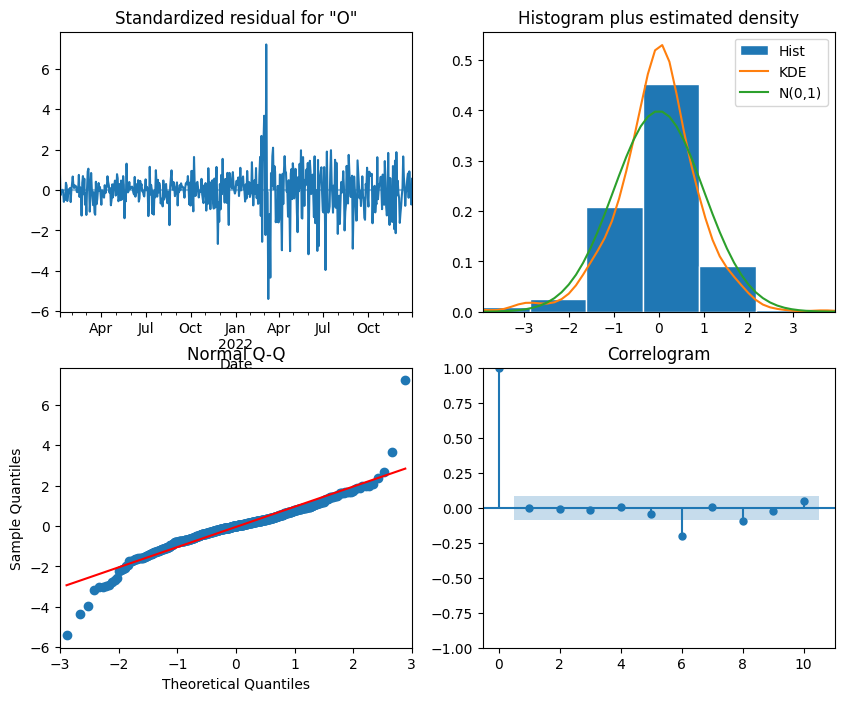

In [34]:
oil_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


### **1. Standardized Residulal** : This residual doesnt show any pattern and are randomly distributed around zero.
### **2. Histogram Plust esitmeted density** : Residuals are normally distriuted
### **3. Normal Q-Q Plot** : Most of the are along red line
### **4. Correlogram** : Its and ACF plot of residuals at diffrent lag and their is no autocorrelation seen

In [35]:
# Get in-sample predictions
training_data_predictions = oil_model_fit.get_prediction(start=train_data_oil.dropna().index.min(),
                                                      end=train_data_oil.dropna().index.max(),
                                                      dynamic=False)

train_data_oil[['lower Oil predictions','Higher Oil predictions']] = training_data_predictions.conf_int()

# Create a new column for the predicted values
train_data_oil['Oil predictions'] = training_data_predictions.predicted_mean

train_data_oil

<ipython-input-35-a9cd94b151cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_oil[['lower Oil predictions','Higher Oil predictions']] = training_data_predictions.conf_int()
<ipython-input-35-a9cd94b151cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_oil[['lower Oil predictions','Higher Oil predictions']] = training_data_predictions.conf_int()
<ipython-input-35-a9cd94b151cd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

,Original_Oil_Price,lower Oil predictions,Higher Oil predictions,Oil predictions
Date,,,,
2021-01-04,51.35,-2771.812463,2771.812463,0.000000
2021-01-05,50.75,-1308.886631,1462.936653,77.025011
2021-01-06,53.29,44.983820,55.316500,50.150160
2021-01-07,53.84,49.810223,59.098128,54.454176
2021-01-08,54.39,50.188282,59.157138,54.672710
...,...,...,...,...
2022-12-26,82.23,76.553045,84.265083,80.409064
2022-12-27,82.23,78.424379,86.136414,82.280396
2022-12-28,81.96,78.405246,86.117277,82.261262


In [36]:
forecast = oil_model_fit.get_forecast(steps=25, alpha=0.05)
forecast.predicted_mean

2023-01-02    81.398702
2023-01-03    81.512476
2023-01-04    81.446938
2023-01-05    81.418097
2023-01-06    81.392969
2023-01-09    81.381313
2023-01-10    81.368553
2023-01-11    81.355409
2023-01-12    81.341241
2023-01-13    81.327035
2023-01-16    81.312852
2023-01-17    81.298746
2023-01-18    81.284651
2023-01-19    81.270556
2023-01-20    81.256456
2023-01-23    81.242354
2023-01-24    81.228251
2023-01-25    81.214149
2023-01-26    81.200048
2023-01-27    81.185946
2023-01-30    81.171845
2023-01-31    81.157743
2023-02-01    81.143641
2023-02-02    81.129539
2023-02-03    81.115438
Freq: B, Name: predicted_mean, dtype: float64

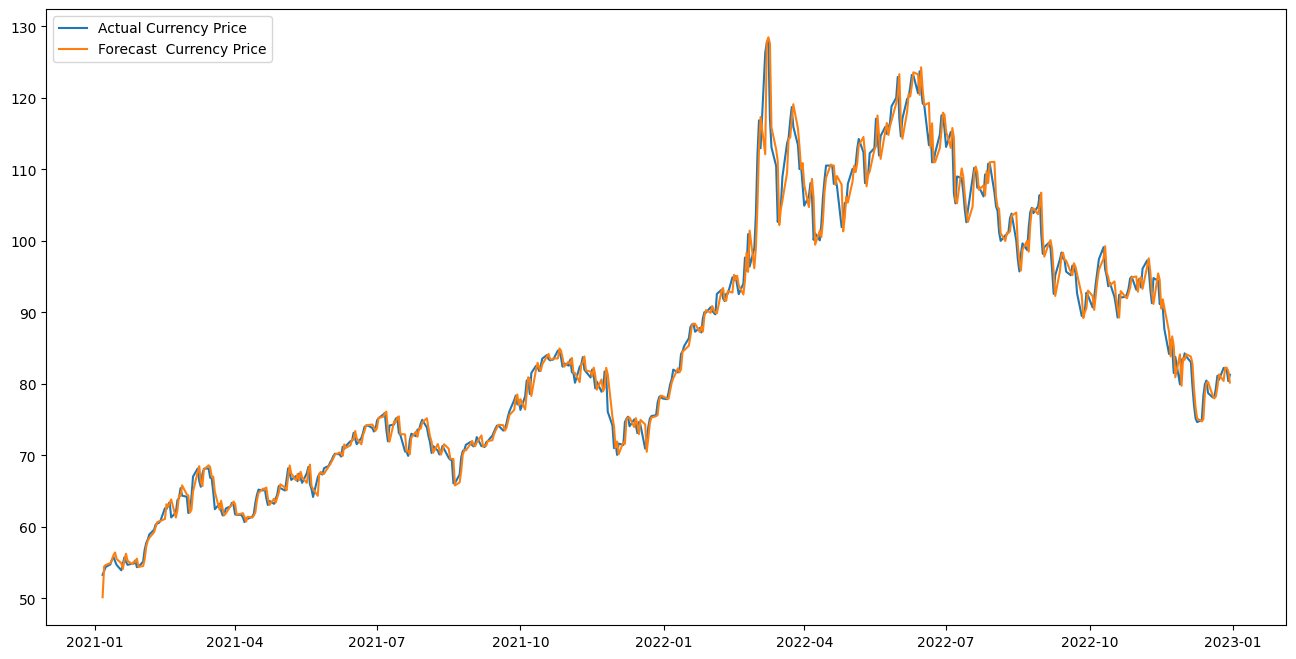

In [38]:
plt.figure(figsize=(16,8))
plt.plot(train_data_oil['Original_Oil_Price'][2:],label="Actual Currency Price")
plt.plot(train_data_oil['Oil predictions'][2:],label="Forecast  Currency Price")
plt.legend(loc="upper left")

# One Day Steap Ahead -Walk-Forward Validation



In [39]:



# define model configuration
my_order = (1,2,3)

# lists to collect forecasts
forecasts = []

# walk-forward validation
history = [x for x in train_data_oil['Original_Oil_Price']]
for i in range(len(test_data_oil['Original_Oil_Price'])):

    #auto = auto_arima(history, error_action='ignore', suppress_warnings=True)
    #my_order = auto.order
    model = ARIMA(history, order=my_order)
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=1, alpha=0.05)
    forecasts.append(forecast.predicted_mean[0])
    history.append(test_data_oil['Original_Oil_Price'][i])

    print("my_order is {} for date {} and predicted value is {} and actual value is {} ".format(my_order,test_data_oil['Original_Oil_Price'].index[i],forecast.predicted_mean[0],test_data_oil['Original_Oil_Price'][test_data_oil['Original_Oil_Price'].index[i]]))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=test_data_oil['Original_Oil_Price'].index)



my_order is (1, 2, 3) for date 2023-01-02 00:00:00 and predicted value is 81.35179058725254 and actual value is 82.05 
my_order is (1, 2, 3) for date 2023-01-03 00:00:00 and predicted value is 82.2626807551423 and actual value is 82.05 
my_order is (1, 2, 3) for date 2023-01-04 00:00:00 and predicted value is 82.00218442627931 and actual value is 76.88 
my_order is (1, 2, 3) for date 2023-01-05 00:00:00 and predicted value is 76.42166186370973 and actual value is 75.77 
my_order is (1, 2, 3) for date 2023-01-06 00:00:00 and predicted value is 75.74850740270861 and actual value is 76.15 
my_order is (1, 2, 3) for date 2023-01-09 00:00:00 and predicted value is 76.24584281471323 and actual value is 77.57 
my_order is (1, 2, 3) for date 2023-01-10 00:00:00 and predicted value is 77.76314059042947 and actual value is 77.0 
my_order is (1, 2, 3) for date 2023-01-11 00:00:00 and predicted value is 76.94775100472019 and actual value is 78.23 
my_order is (1, 2, 3) for date 2023-01-12 00:00:00

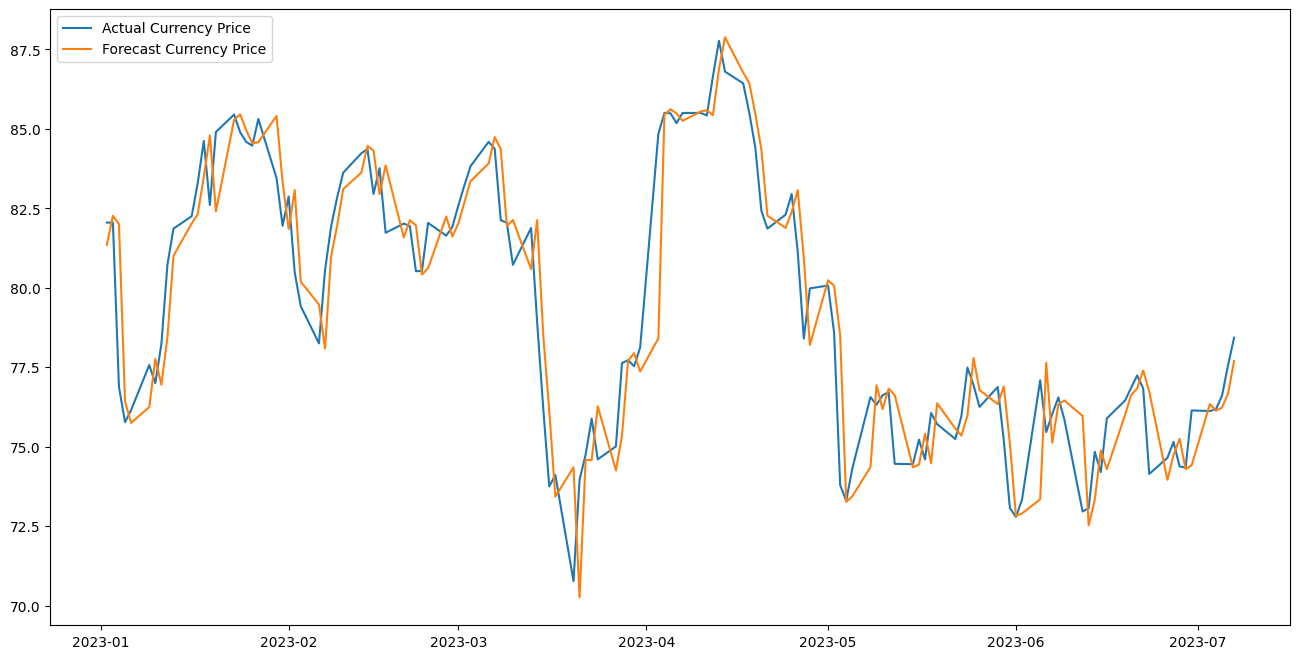

In [40]:
plt.figure(figsize=(16,8))
plt.plot(test_data_oil['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"Mean Absolute Error": mae, "Mean Squared Error": mse, "Root Mean Squared Error": rmse, "Mean Absolute Percentage Error": mape}




# Calcualate metrics of model for One Day Forecasting

In [42]:


metrics = calculate_metrics(test_data_oil['Original_Oil_Price'], forecast_df['Forecast'])
metrics

{'Mean Absolute Error': 1.1088037984087675,
 'Mean Squared Error': 2.373507771546103,
 'Root Mean Squared Error': 1.5406192818299085,
 'Mean Absolute Percentage Error': 1.4130556590810637}

# Five Day Steap Ahead -Walk-Forward Validation



In [43]:
import pandas as pd


# define model configuration
my_order = (1,2,3)

# lists to collect forecasts
forecasts = []

# walk-forward validation
history = [x for x in train_data_oil['Original_Oil_Price']]
for i in range(0, len(test_data_oil['Original_Oil_Price']), 5):  # now stepping by 5
    # Commenting below lines a model not predicting any new model , so used the value found earlier
    #auto = auto_arima(history, error_action='ignore', suppress_warnings=True)
    #my_order = auto.order

    model = ARIMA(history, order=my_order)
    model_fit = model.fit()

    # if less than 5 steps remaining, adjust steps to fit
    steps = min(5, len(test_data_oil['Original_Oil_Price']) - i)

    forecast = model_fit.get_forecast(steps=steps, alpha=0.05)

    forecasts.extend(forecast.predicted_mean)  # using extend instead of append

    # Append all forecasted values to the history
    history.extend(test_data_oil['Original_Oil_Price'][i:i+steps])
    print("my_order is {} for Week Starting {} and predicted value is {} and actual value is {}".format(my_order,test_data_oil['Original_Oil_Price'].index[i],forecast.predicted_mean,test_data_oil['Original_Oil_Price'][test_data_oil['Original_Oil_Price'].index[i:i+steps]].values.tolist()))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=test_data_oil['Original_Oil_Price'].index)


my_order is (1, 2, 3) for Week Starting 2023-01-02 00:00:00 and predicted value is [81.35179059 81.48376433 81.47004432 81.5929899  81.5877386 ] and actual value is [82.05, 82.05, 76.88, 75.77, 76.15]
my_order is (1, 2, 3) for Week Starting 2023-01-09 00:00:00 and predicted value is [76.24584281 76.28268385 76.3378579  76.37579412 76.4299384 ] and actual value is [77.57, 77.0, 78.23, 80.73, 81.86]
my_order is (1, 2, 3) for Week Starting 2023-01-16 00:00:00 and predicted value is [82.02035803 82.06084662 82.13389219 82.17624497 82.2475331 ] and actual value is [82.25, 83.3, 84.62, 82.6, 84.9]
my_order is (1, 2, 3) for Week Starting 2023-01-23 00:00:00 and predicted value is [85.2866551  85.2709621  85.40724284 85.40097314 85.52841488] and actual value is [85.45, 84.89, 84.59, 84.47, 85.31]
my_order is (1, 2, 3) for Week Starting 2023-01-30 00:00:00 and predicted value is [85.40464825 85.50321752 85.53178198 85.6260381  85.65864997] and actual value is [83.45, 81.95, 82.87, 80.48, 79.42]

# Calcualate metrics of model for Five  Day Forecasting

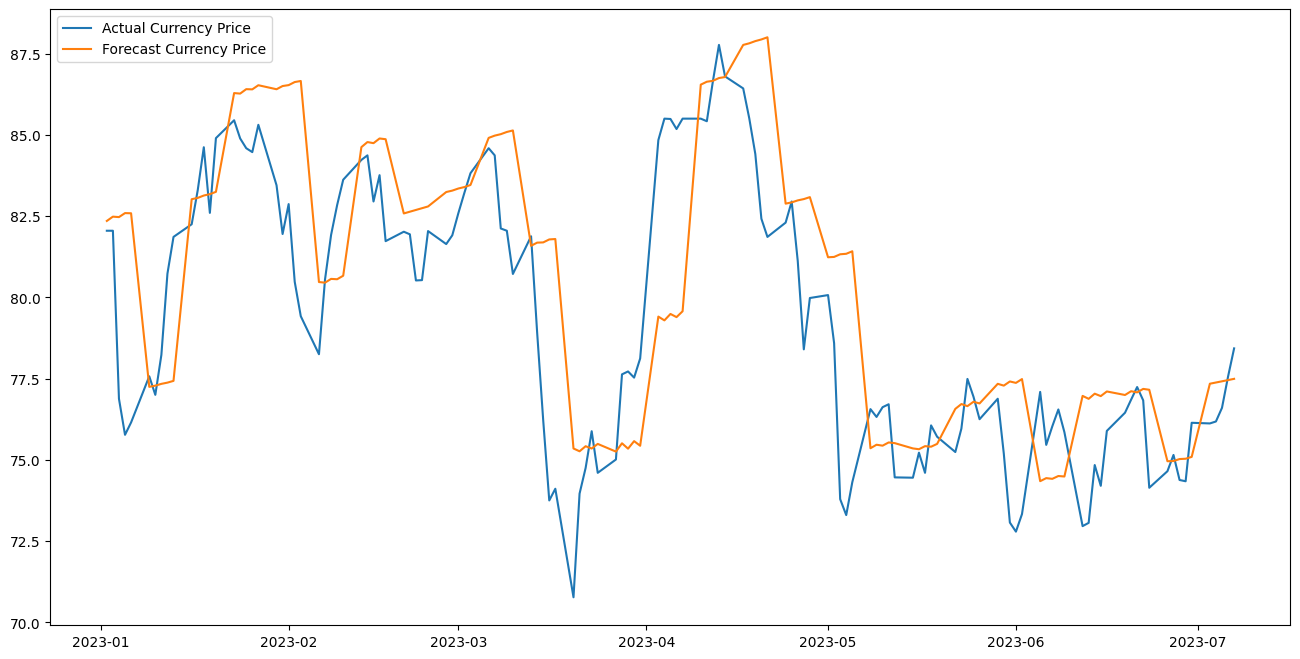

In [47]:
plt.figure(figsize=(16,8))
plt.plot(test_data_oil['Original_Oil_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast']+1,label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [48]:


metrics = calculate_metrics(test_data_oil['Original_Oil_Price'], forecast_df['Forecast'])
metrics

{'Mean Absolute Error': 2.063890496022513,
 'Mean Squared Error': 8.019850564659363,
 'Root Mean Squared Error': 2.8319340678517504,
 'Mean Absolute Percentage Error': 2.6188076211687847}